In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, dirname
import random
from random import random as rand

In [2]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [3]:
subj_list = ['03','04','05','06','07',
             '08','09','10','11','12',
             '14','15','16','17','18',
             '19','20','21','22','24',
             '25','26','27','29']

In [4]:
today = date.today().strftime("%Y%m%d")
root_dir = '..'
behav_dir = root_dir + '/behav_data'
script_dir = root_dir + '/scripts'
output_dir = script_dir

In [5]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937
runs = ['r01','r02','r03','r04']
blocks = ['b01','b02','b03','b04','b05','b06','b07','b08']
trials = ['t01','t02','t03','t04','t05','t06','t07','t08','t09','t10','t11','t12']

In [6]:
def convert_ID(ID):
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [7]:
def calc_mrew(behav_datum):
    datum = scipy.io.loadmat(behav_datum)
    
    st = 4         ## time spend(second) in each trial
    nS = 60 * st   ## Number of samples(=frame)

    wait = 12      ## useless trials
    ntrial = 12
    nblock = 8
    nrun = 4
    tpr = ntrial * nblock + 1  ## trials per a run

    subj = 'GL' + nn
    behav_datum = behav_dir + '/%s-fmri.mat' %subj
    datum = scipy.io.loadmat(behav_datum)

    end = datum['LearnTrialStartTime'].shape[1]
    startTime = datum['LearnTrialStartTime'][0,range(0,end,tpr)]
    cnt_hit_all = np.zeros((datum['targetID'].shape[1],nS))

    for i,ID in enumerate(np.concatenate(datum['targetID'])[wait:]):
        pos = datum['boxSize']*convert_ID(ID)
        xy = datum['allXY'][:,nS*i:nS*(i+1)]
        err = xy - np.int16(np.ones((2,nS))*pos.T)
        cnt_hit_all[i,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)
    assert np.sum(np.sum(cnt_hit_all,axis=1)-datum['cnt_hit'])==0
    print('Matched...')

    rew_bin = np.zeros((nrun,st*tpr))
    for r in range(nrun):
        tem = cnt_hit_all[tpr*r:tpr*(r+1),:].reshape(nS*tpr,1)
        for i in range(st*tpr):
            rew_bin[r,i] = sum(tem[60*i:60*(i+1)])

    max_score =  nS*ntrial   ## total frames in a block
    temp = rew_bin[:,st:].reshape(nrun*st*ntrial*nblock)
    norm_mrew = np.zeros(nblock*nrun)
    for i in range(nblock*nrun):
        norm_mrew[i] = sum(temp[st*ntrial*i:st*ntrial*(i+1)])/max_score
    
    return norm_mrew

In [8]:
def gr4allXY(run):
    ## get a range for allXY
    s = 60*4        # sample rate
    tpb = 12        # trials per block
    nblock = 8
    tpr = tpb*nblock + 1  # trials per run
    switcher = {
        'r01':np.arange(0,s*tpr),
        'r02':np.arange(s*tpr,s*tpr*2),
        'r03':np.arange(s*tpr*2,s*tpr*3),
        'r04':np.arange(s*tpr*3,s*tpr*4),
        'r05':np.arange(s*tpr*4,s*tpr*5),
        'r06':np.arange(s*tpr*5,s*tpr*6),
        'r07':np.arange(s*tpr*6,s*tpr*7),
        'b01':np.arange(s,s+s*tpb),
        'b02':np.arange(s+s*tpb,s+s*tpb*2),
        'b03':np.arange(s+s*tpb*2,s+s*tpb*3),
        'b04':np.arange(s+s*tpb*3,s+s*tpb*4),
        'b05':np.arange(s+s*tpb*4,s+s*tpb*5),
        'b06':np.arange(s+s*tpb*5,s+s*tpb*6),
        'b07':np.arange(s+s*tpb*6,s+s*tpb*7),
        'b08':np.arange(s+s*tpb*7,s+s*tpb*8),
        't01':np.arange(0,s),
        't02':np.arange(s,s*2),
        't03':np.arange(s*2,s*3),
        't04':np.arange(s*3,s*4),
        't05':np.arange(s*4,s*5),
        't06':np.arange(s*5,s*6),
        't07':np.arange(s*6,s*7),
        't08':np.arange(s*7,s*8),
        't09':np.arange(s*8,s*9),
        't10':np.arange(s*9,s*10),
        't11':np.arange(s*10,s*11),
        't12':np.arange(s*11,s*12)
    }
    return switcher.get(run,"Invalid RUN")

# Success rate

In [9]:
tt = 4*8 # total number of blocks (nrun * nblock)
rew = {}
for nn in subj_list:
    subj = 'GL' + nn
    behav_datum = behav_dir + '/%s-fmri.mat' %subj
    rew[subj] = calc_mrew(behav_datum)

Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...


In [10]:
df = pd.DataFrame()
for nn in subj_list:
    subj = 'GL' + nn
    for i in range(tt):
        df.loc[subj,i] = rew[subj][i]

sum_even = 0;
sum_odd = 0;
for i in df.columns:
    if i % 2 == 0:
        sum_even += df[i]
    else:
        sum_odd += df[i]
df['FB'] = sum_even
df['nFB'] = sum_odd
df['diff'] = df['FB'] - df['nFB']
df.to_csv('./AspectRatio_diff.txt', columns=['diff'], header=None, index=None)
df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,FB,nFB,diff
GL03,0.076389,0.000347,0.075694,0.050347,0.066319,0.073611,0.247917,0.076389,0.260764,0.086111,...,0.067708,0.590972,0.067361,0.675694,0.070833,0.675000,0.123611,6.285069,1.485417,4.799653
GL04,0.287153,0.313194,0.384722,0.176736,0.386458,0.196181,0.485764,0.210417,0.377778,0.163194,...,0.112153,0.359722,0.225347,0.520486,0.268056,0.398611,0.300347,6.476042,2.989931,3.486111
GL05,0.092708,0.001736,0.147222,0.062500,0.204167,0.049306,0.417361,0.038194,0.075347,0.011111,...,0.103125,0.271875,0.157986,0.487847,0.171181,0.388194,0.100000,4.619792,1.339583,3.280208
GL06,0.029167,0.021528,0.073264,0.012847,0.207292,0.131597,0.124653,0.014583,0.165278,0.045486,...,0.096875,0.326042,0.064583,0.399653,0.171875,0.360069,0.163542,3.984722,1.177778,2.806944
GL07,0.128819,0.018056,0.213889,0.014236,0.222917,0.034028,0.231597,0.009375,0.105556,0.070486,...,0.025694,0.204514,0.013194,0.228472,0.068056,0.205556,0.106597,3.011111,0.746528,2.264583
GL08,0.175694,0.009028,0.345486,0.075347,0.393056,0.015625,0.320139,0.056944,0.530903,0.159028,...,0.094444,0.486111,0.245833,0.549306,0.291667,0.438889,0.375694,6.771181,2.280903,4.490278
GL09,0.107292,0.072569,0.121875,0.078125,0.090972,0.017014,0.184375,0.070486,0.134375,0.022222,...,0.047222,0.289236,0.102431,0.276389,0.037500,0.368403,0.104861,3.532986,1.184028,2.348958
GL10,0.045486,0.007986,0.058681,0.088889,0.033681,0.006250,0.165625,0.007639,0.257292,0.004514,...,0.150694,0.453472,0.169444,0.442014,0.104514,0.254514,0.120833,3.879167,1.451736,2.427431
GL11,0.149306,0.004514,0.004514,0.039931,0.303125,0.218056,0.317708,0.290278,0.322569,0.261458,...,0.164583,0.329514,0.093750,0.328472,0.009722,0.391667,0.062153,5.044792,1.692708,3.352083
GL12,0.054514,0.016667,0.021528,0.025347,0.007292,0.016667,0.018056,0.011111,0.159722,0.017361,...,0.115972,0.105208,0.069444,0.344792,0.070833,0.237847,0.102083,2.038889,0.879861,1.159028


Text(0.5, 0, 'blocks')

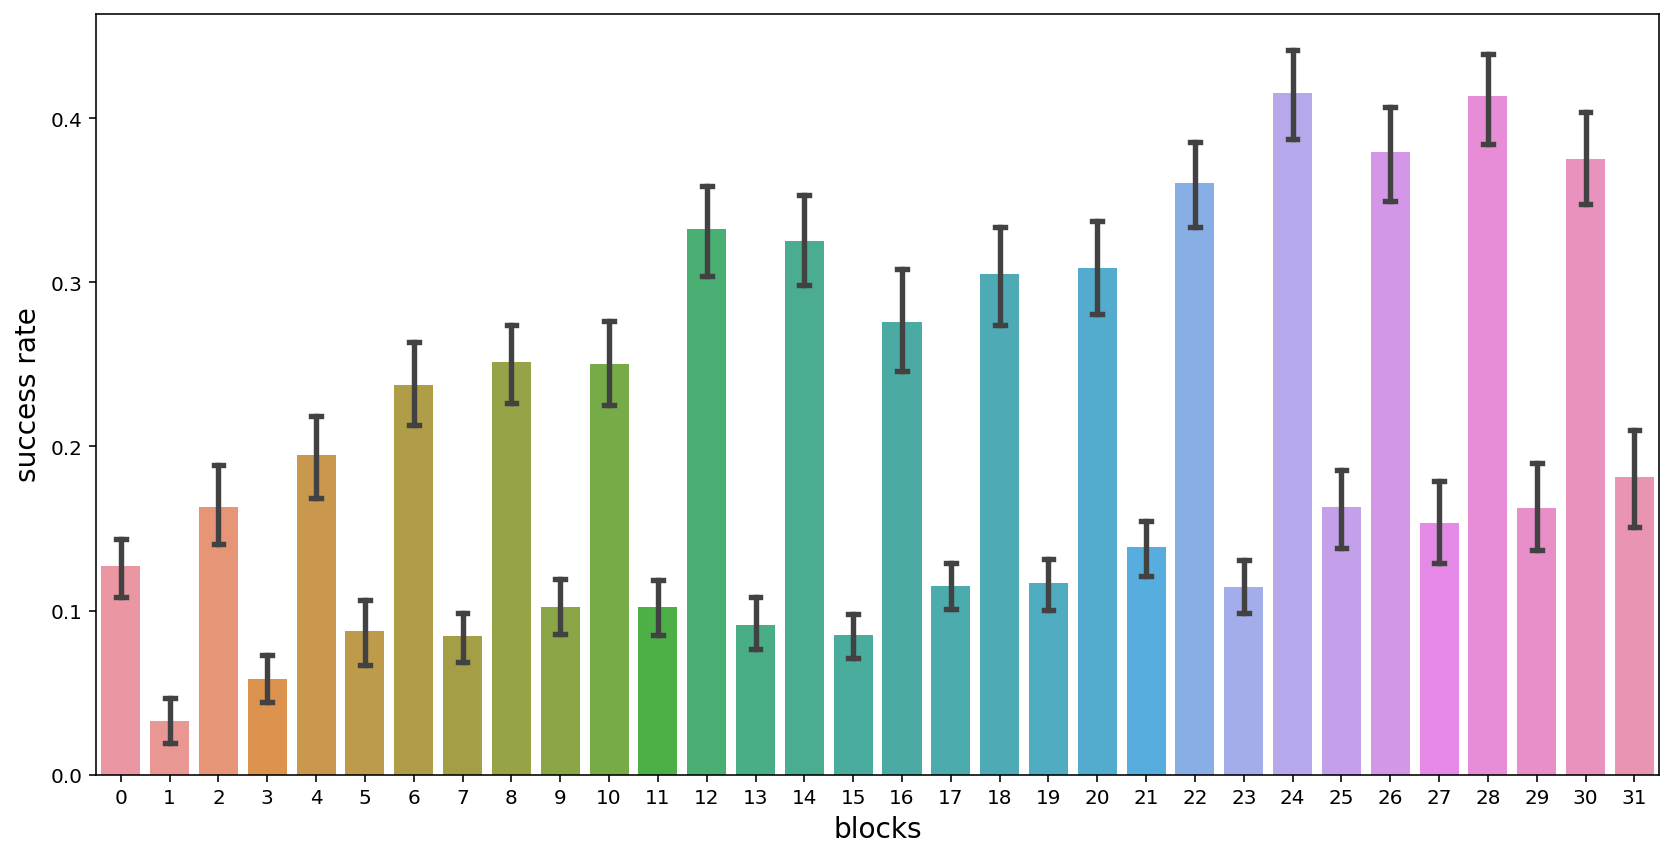

In [11]:
plt.figure(figsize=(14, 7))
sns.barplot(data=df[range(tt)], ci=100*sigma_1, capsize=.2)
plt.ylabel('success rate', size=14)
plt.xlabel('blocks', size=14)

In [12]:
## wide to long
dk = df.reset_index().melt(id_vars='index' ,value_vars=df.columns[:32])
dk['hue'] = ['FB' if (col%2==0) else 'nFB' for col in dk['variable']]
dk

,index,variable,value,hue
0,GL03,0,0.076389,FB
1,GL04,0,0.287153,FB
2,GL05,0,0.092708,FB
3,GL06,0,0.029167,FB
4,GL07,0,0.128819,FB
...,...,...,...,...
763,GL24,31,0.003472,nFB
764,GL25,31,0.451736,nFB
765,GL26,31,0.118403,nFB
766,GL27,31,0.095833,nFB


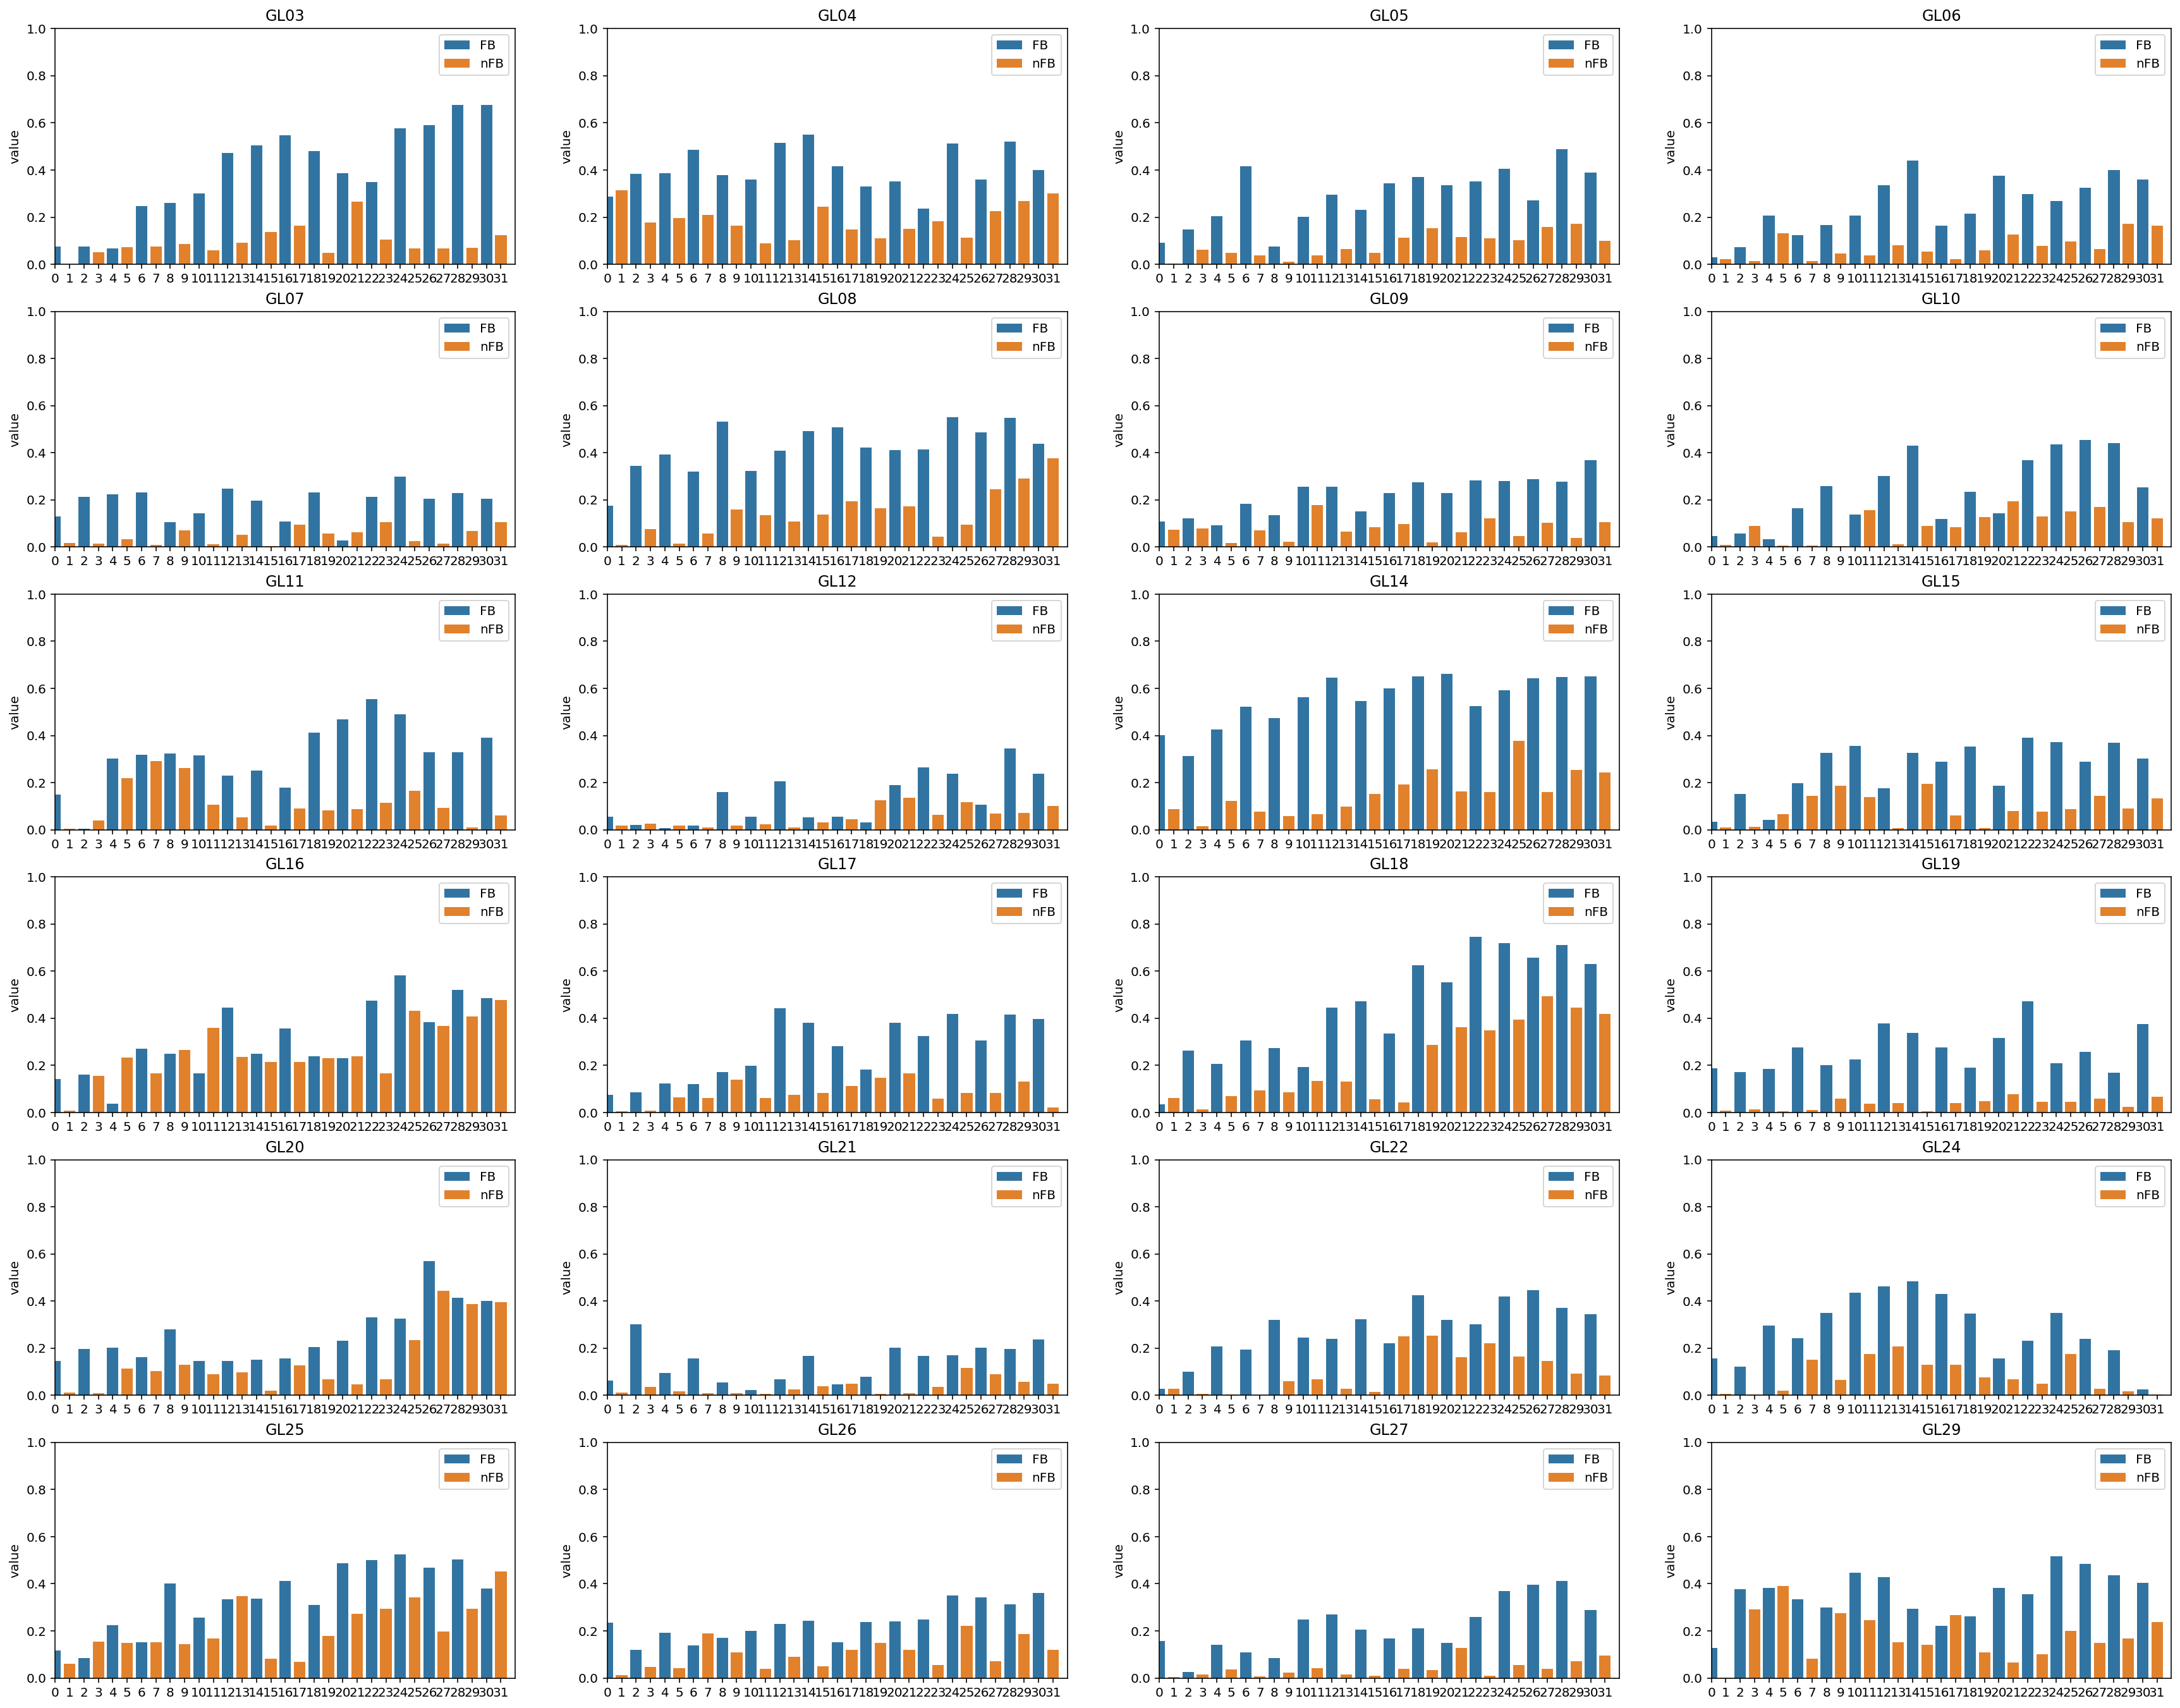

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 24)
for i, nn in enumerate(subj_list):
    subj = 'GL' + nn
    plt.subplot(6, 4, i+1)
#     sns.scatterplot(data=df.loc[subj][:tt])
#     sns.barplot(x=np.arange(32), y=df.loc[subj][np.arange(32)])
    sns.barplot(x='variable', y='value', data=dk[dk['index']==subj], hue='hue', dodge=False)
    plt.title(subj)
    plt.ylim(0, 1)
    plt.xlim(0, 32)
    plt.xlabel(None)
    plt.legend()

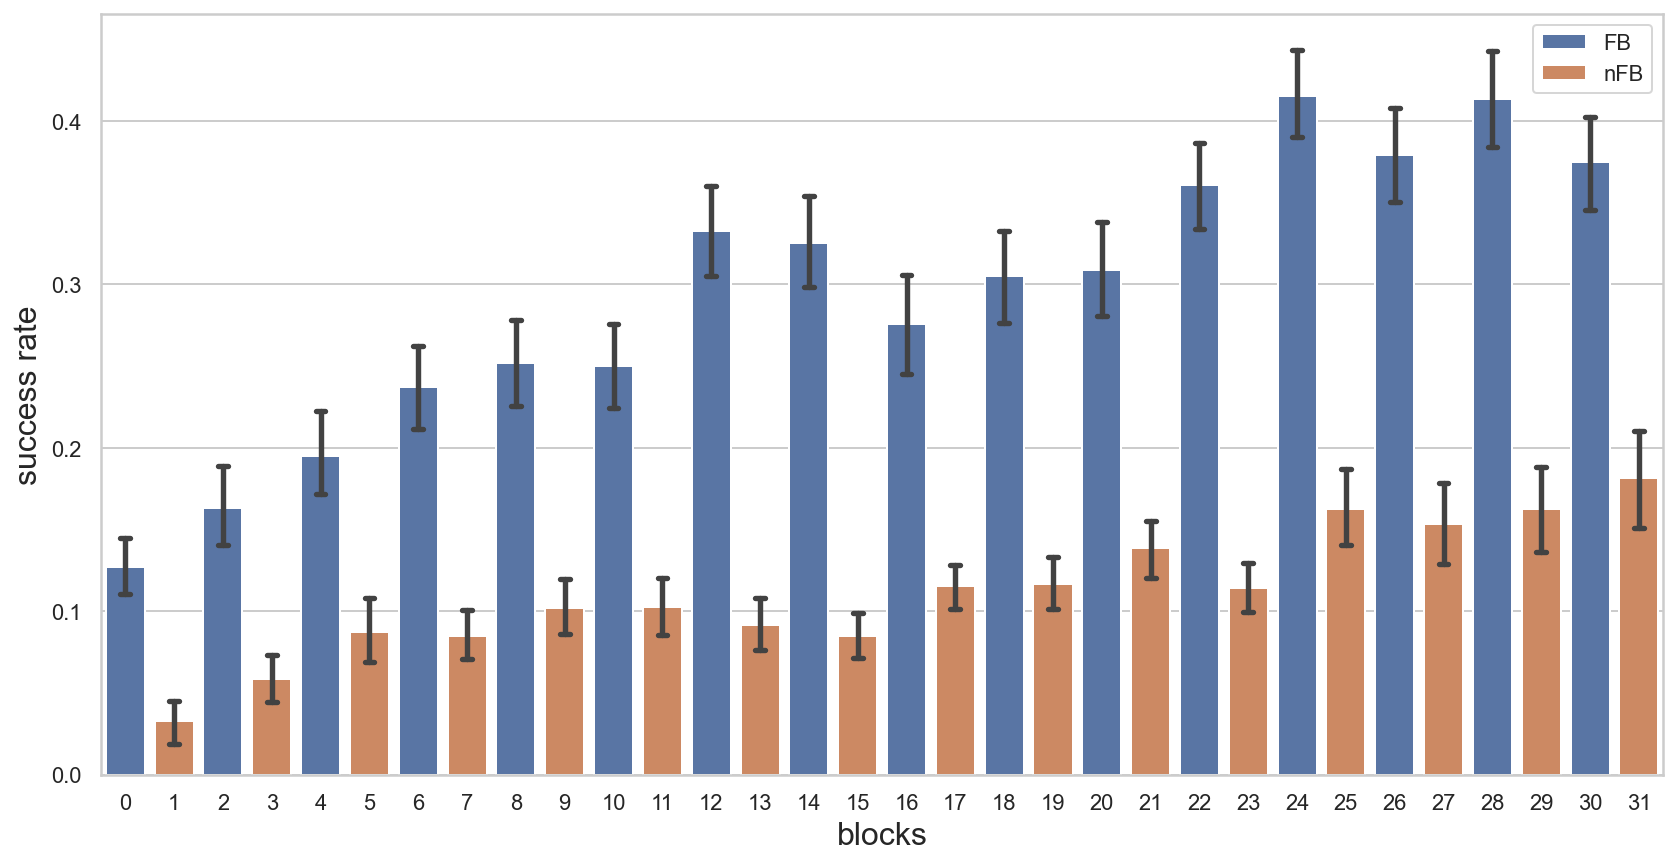

In [15]:
sns.set(style="whitegrid")

ax = plt.figure(figsize=(14, 7))
sns.barplot(x='variable', y='value', data=dk, hue='hue', ci=100*sigma_1, capsize=.2, dodge=False)
plt.ylabel('success rate', size=16)
plt.xlabel('blocks', size=16)
plt.legend()

ax.savefig(join(output_dir,today+'.behav.group.png'), dpi=300)